# FAST AI JOURNEY: PART 1. LESSON 1. AIRCRAFT CLASSIFIER PROJECT.

In this project we will build an aircraft image classifier from scratch and see what results we can get.

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

## Looking at the data

In [3]:
folder = 'military'
file = 'urls_military.csv'

In [6]:
folder = 'civilian' 
file = 'urls_civilian.csv'

In [9]:
folder = 'uav'
file = 'urls_uav.csv'

In [4]:
path = Path('data/aircrafts')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [ ]:
download_images(path/file, dest, max_pics=2500)

In [5]:
classes = ['military','civilian', 'uav']

In [6]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_workers=8)

military


civilian


uav


/opt/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:771: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [7]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [7]:
data.classes

['civilian', 'military', 'uav']

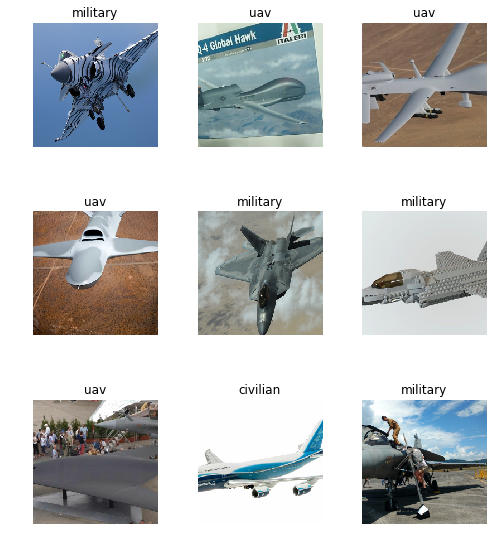

In [19]:
data.show_batch(rows=3, figsize=(7,8))

## Training: resnet34

In [8]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [21]:
learn.fit_one_cycle(4)

Total time: 04:26
epoch  train_loss  valid_loss  error_rate
1      0.586706    0.244901    0.091019    (01:07)
2      0.378019    0.194390    0.070388    (01:05)
3      0.276955    0.167394    0.064320    (01:07)
4      0.228534    0.155270    0.055825    (01:06)



In [22]:
interp = ClassificationInterpretation.from_learner(learn)

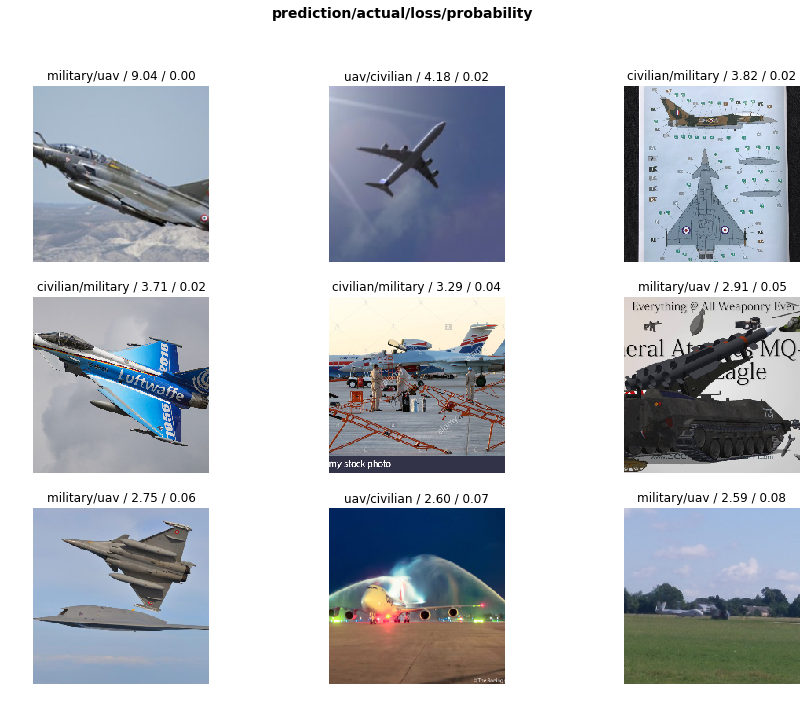

In [23]:
interp.plot_top_losses(9, figsize=(15,11))

In [24]:
learn.save('stage-1')

## Unfreezing, fine-tuning, and learning rates

In [25]:
learn.unfreeze()

In [26]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


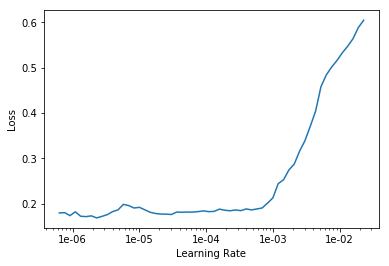

In [27]:
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-4))

Total time: 02:19
epoch  train_loss  valid_loss  error_rate
1      0.187017    0.144961    0.054612    (01:11)
2      0.146533    0.128093    0.044903    (01:07)



In [29]:
learn.save('stage-2')

In [30]:
interp = ClassificationInterpretation.from_learner(learn)

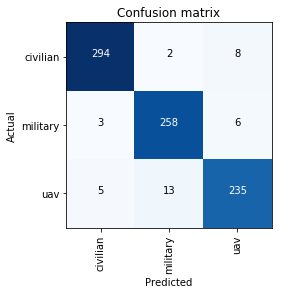

In [31]:
interp.plot_confusion_matrix()

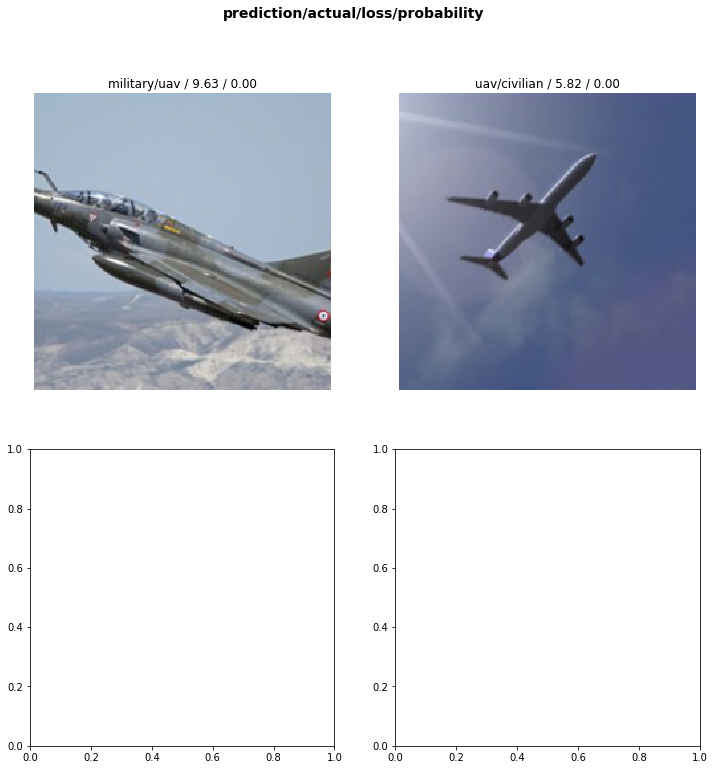

In [32]:
interp.plot_top_losses(2)

## Training: resnet50

In [33]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/jupyter/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 51349484.16it/s]


In [34]:
learn.fit_one_cycle(8, max_lr=slice(1e-3))

Total time: 09:18
epoch  train_loss  valid_loss  error_rate
1      0.573683    0.278996    0.108010    (01:12)
2      0.394604    0.230135    0.084951    (01:10)
3      0.293289    0.195521    0.069175    (01:11)
4      0.229070    0.168518    0.053398    (01:08)
5      0.179292    0.149952    0.048544    (01:09)
6      0.142679    0.152159    0.049757    (01:08)
7      0.123806    0.150222    0.049757    (01:07)
8      0.108286    0.146466    0.047330    (01:09)



In [9]:
learn.save('stage-1-50')

In [9]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-4))

Total time: 05:47
epoch  train_loss  valid_loss  error_rate
1      1.147107    0.700037    0.270631    (01:06)
2      0.793286    0.372576    0.131068    (01:10)
3      0.557968    0.278164    0.098301    (01:11)
4      0.435438    0.247399    0.077670    (01:09)
5      0.373115    0.244994    0.077670    (01:09)



In [15]:
learn.load('stage-1')

ClassificationLearner(data=<fastai.vision.data.ImageDataBunch object at 0x7f2d16554b00>, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `FileDeleter` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

First we need to get the file paths from our top_losses. Here's a handy function that pulls out all our top_losses:

In [16]:
interp = ClassificationInterpretation.from_learner(learn)

In [17]:
from fastai.widgets import *

losses,idxs = interp.top_losses()
top_loss_paths = data.valid_ds.x[idxs]

Now we can pass in these paths to our widget.

In [18]:
fd = ImageDeleter(data, idxs)

'No images to show :)'

In [8]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

In [9]:
learn.fit_one_cycle(8, max_lr=slice(1e-3))

Total time: 08:18
epoch  train_loss  valid_loss  error_rate
1      0.627473    0.214385    0.085897    (01:05)
2      0.408773    0.185630    0.067949    (01:00)
3      0.297248    0.156948    0.043590    (01:00)
4      0.219906    0.131173    0.039744    (01:02)
5      0.181462    0.115148    0.042308    (01:01)
6      0.158973    0.108574    0.039744    (01:01)
7      0.146635    0.103093    0.037179    (01:04)
8      0.121705    0.101903    0.033333    (01:01)



In [10]:
learn.save('stage-1-50-clean')

In [11]:
learn.load('stage-1-50-clean')

ClassificationLearner(data=<fastai.vision.data.ImageDataBunch object at 0x7f54574dc668>, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        